# Timing Test Simple Client

In [86]:
!pip3 install pyserial
!pip3 install matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 7.8 MB 10.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 13.6 MB/s eta 0:00:01
     |████████████████████████████████| 13.3 MB 528 kB/s eta 0:00:01
     |████████████████████████████████| 3.4 MB 7.3 MB/s eta 0:00:01
     |████████████████████████████████| 66 kB 4.8 MB/s eta 0:00:01
     |████████████████████████████████| 103 kB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 244 kB 4.2 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


## Constants and imports
This must match the STM definitions

In [2]:
import serial
import matplotlib.pyplot as plt

START_TEST        = 0b100
BEFORE_SOLENOID   = 0b001
AFTER_SOLENOID    = 0b010
BEAM_READ         = 0b011 
END_TEST          = 0b110   

PACKET_SIZE       = 5

## Simple data collection
Collects all data until an END_TEST is seen

In [28]:
collected_data = []

def read_data(ser):
    stop = False
    while not stop:
        if ser.in_waiting >= PACKET_SIZE:
            data = ser.read(PACKET_SIZE)
            identifier = (data[4] >> 5) & 0x07
            time_micro = (data[0] << 24) | (data[1] << 16) | (data[2] << 8) | data[3]


            if identifier == END_TEST:
                stop = True
            
            delimiter = data[4] & 0x1F
                
            if delimiter == 0x1F:
                collected_data.append(data)
                print(f"Identifier: {identifier}, Time: {time_micro}")
            else:
                print("Delimiter not found, packet discarded.")

if __name__ == "__main__":
    ser = serial.Serial('/dev/cu.usbserial-110', 9600)  # Adjust the port as needed
    read_data(ser)


Identifier: 4, Time: 117515007
Identifier: 1, Time: 117515017
Identifier: 2, Time: 117590003
Identifier: 3, Time: 121876085
Identifier: 6, Time: 121876095


In [26]:
identifiers = []
analog_values = []
time_micros = []

for entry in collected_data:
    identifier = (entry[4] >> 5) & 0x07
    time_micro = (entry[0] << 24) | (entry[1] << 16) | (entry[2] << 8) | entry[3]

    identifiers.append(identifier)
    time_micros.append(time_micro)


time_micros = [(x-time_micros[0])/(1e6) for x in time_micros]

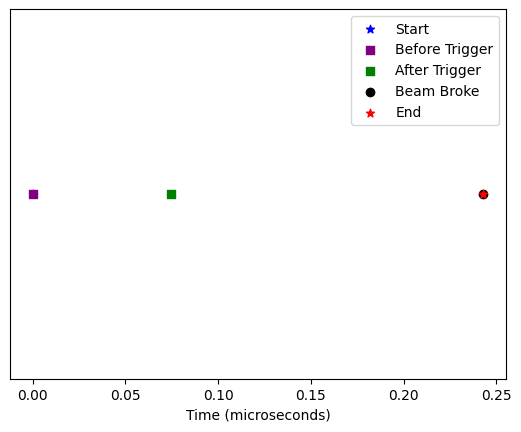

In [30]:
# Plot each point with the specified style and color
for identifier, time_micro in zip(identifiers, time_micros):
    if identifier == START_TEST:
        plt.scatter(time_micro,0, color='blue', marker='*', label='Start')
    elif identifier == END_TEST:
        plt.scatter(time_micro, 0, color='red', marker='*', label='End')
    elif identifier == BEFORE_SOLENOID:
        plt.scatter(time_micro, 0, color='purple', marker='s', label='Before Trigger')
    elif identifier == AFTER_SOLENOID:
        plt.scatter(time_micro, 0, color='green', marker='s', label='After Trigger')
    else:
        plt.scatter(time_micro, 0, color='black', marker='o', label='Beam Broke')

# Adding labels and title
plt.xlabel('Time (microseconds)')
plt.yticks([])  # Hide y-axis
#plt.title('Analog Value vs. Time')

# Remove duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()



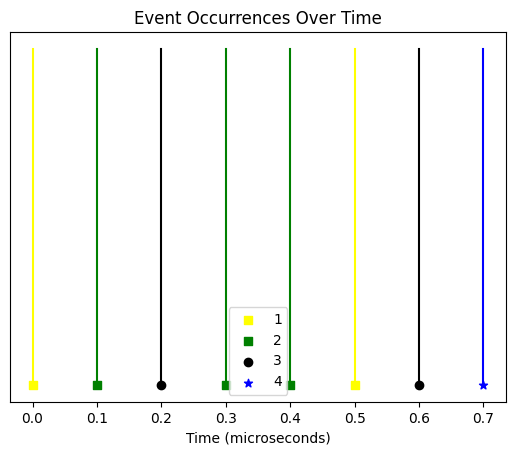

In [6]:
# Define colors and markers for each identifier category
styles = {
    START_TEST: {"color": "blue", "marker": "*"},
    END_TEST: {"color": "red", "marker": "*"},
    BEFORE_SOLENOID: {"color": "yellow", "marker": "s"},
    AFTER_SOLENOID: {"color": "green", "marker": "s"},
    BEAM_READ: {"color": "black", "marker": "o"}
}

# Plot each point as a vertical line on the x-axis
for identifier, time_micro in zip(identifiers, time_micros):
    style = styles.get(identifier, styles[identifier])
    plt.plot([time_micro, time_micro], [0, 1], color=style["color"])
    plt.scatter(time_micro, 0, color=style["color"], marker=style["marker"], label=identifier if identifier not in plt.gca().get_legend_handles_labels()[1] else "")

# Adding labels and title
plt.xlabel('Time (microseconds)')
plt.yticks([])  # Hide y-axis
plt.title('Event Occurrences Over Time')

# Remove duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()
